# Robustness graphs

This notebook provides the graphs for the robustness section

## Packages and options

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
fn_results = "../results/results_no_gams.parquet"
map_countries = {
    "FR": "France",
    "DE": "Germany",
    "GR": "Greece",
}

## Get data

In [38]:
df_in = pd.read_parquet(fn_results)

In [39]:
df_agg = (
    df_in
    .groupby(["country", "renewableDemandShare", "yearWeather", "yearDemand"], as_index=False)
    [["MAX_STO", "shareWind", "netSupply"]]
    .mean()
    .assign(
        # convert to percentage and set RE share to zero for non-renewable scenarios
        shareWind=lambda df: (df["renewableDemandShare"] >0).astype(int)*df["shareWind"] * 100,
        renewableDemandShare=lambda df: (df["renewableDemandShare"] * 100).astype(int)
    )
)

## Graphs

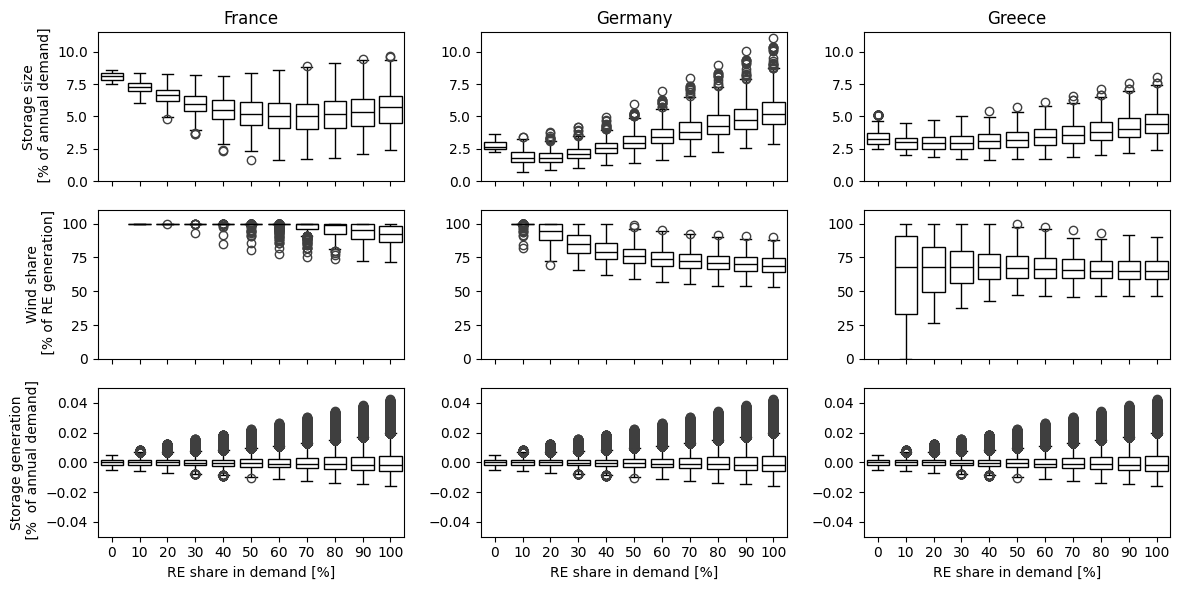

In [40]:
plot_net_supply = True

n_rows = 3 if plot_net_supply else 2

fig, axs = plt.subplots(n_rows, 3, figsize=(12, 6), sharex=True)

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
df_agg["country"].unique()
for i, country in enumerate(["FR", "DE", "GR"]):
    ax = axs[0, i]
    df_p = df_agg.query(f"country == '{country}'") 
    # first row: Storage size
    sns.boxplot(
        df_p, 
        x="renewableDemandShare",
        y="MAX_STO",
        ax=ax,
        **PROPS
    )
    ax.set_ylim(0, 11.5)
    if i == 0:
        ax.set_ylabel("Storage size\n [% of annual demand]")
    else:
        ax.set_ylabel("")
    
    ax.set_title(map_countries[country])
    # second row: Wind share
    ax = axs[1, i]
    sns.boxplot(
        df_p[df_p["renewableDemandShare"] > 0], 
        x="renewableDemandShare",
        y="shareWind",
        ax=ax,
        **PROPS
    )
    if i == 0:
        ax.set_ylabel("Wind share\n [% of RE generation]")
    else:
        ax.set_ylabel("")
    ax.set_ylim(0, 110)
    ax.set_xlabel("RE share in demand [%]")
    
    # third row: Net supply
    if plot_net_supply:
        ax = axs[2, i]
        df_p = df_in.query("country == 'DE'").assign(
            renewableDemandShare=lambda df: (df["renewableDemandShare"]*100).astype(int)
        )
        sns.boxplot(
            df_p,
            x="renewableDemandShare",
            y="netSupply",
            ax=ax,
            **PROPS,
        )
        if i == 0:
            ax.set_ylabel("Storage generation\n [%  of annual demand]")
        else:
            ax.set_ylabel("")
        ax.set_ylim(-0.05, 0.05)
    
    # set the xlabels
    ax.set_xlabel("RE share in demand [%]")
        
                
    
plt.tight_layout()
plt.savefig("../figures/storage_capacity_and_wind_share.png", dpi=300)
    